# FYP allocation for 2018/19 academic year

In [1]:
import warnings
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matching.games import StudentAllocation

warnings.filterwarnings("ignore")
%matplotlib inline

---
# Cleaning the data

In order to use the `matching` algorithm, we require the data to be "clean". This is effectively just taking the attributes (columns) of interest and removing any erroneous instances (rows).

In [2]:
xls = pd.ExcelFile("data/Anonymised FYP data.xlsx")

raw_ranks = pd.read_excel(xls, "MAIN LIST")
raw_students = pd.read_excel(xls, "MAIN LIST", na_values=["x", "No Choices submitted"])
raw_projects = pd.read_excel(xls, "Project Status")
raw_supervisors = pd.read_excel(xls, "Projects per staff member")


# Students

Valid students must have:
- a ranking (so that supervisors may have a preference over them)
- strict, unique, preferences over some subset of the projects

All other information is unimportant here.

In [3]:
def try_strip_and_upper(string):
    try:
        return string.strip().upper()
    except AttributeError:
        return string


In [4]:
project_cols = list(raw_students.columns[18:40])
students = raw_students[["University_number", "Adjusted Rank"] + project_cols]

students = students[pd.notnull(students["Adjusted Rank"])]
students = students.dropna(subset=project_cols, how="all")

students["University_number"] = students["University_number"].astype(int)
students["Adjusted Rank"] = students["Adjusted Rank"].astype(int)

students.columns = ["student_number", "rank"] + list(range(22))
for col in range(22):
    students[col] = students[col].apply(try_strip_and_upper)

students.to_csv("data/students.csv", index=False)


In [5]:
students.head()


,student_number,rank,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
0,1616419,82,DP16,DP15,CP12,DP09,DP04,DP05,DP22,DP13,...,DP06,DP02,DP03,DP12,DP11,DL18,DL26,DL22,DL21,DL05
1,1673247,237,DP04,AP14,AL01,AP05,DP09,AL07,DP05,AP18,...,DP22,AL02,DP18,DL19,DP10,AP02,AL08,DL05,EP01,EP17
2,1533191,346,AP27,AP21,AP22,AP15,AP16,DP03,DP06,AP09,...,AP06,AP25,AP26,CP20,CP21,AP01,AP02,AP20,DP13,DP07
3,1505546,277,BP05,DL02,BL23,AP10,DL05,CL06,BL12,DL04,...,DL06,AP23,DL13,SL02,DL19,DL15,DP01,BL11,DL25,DL16
4,1601069,321,AL07,BL18,BL19,DL04,DL05,BL09,BL24,BL21,...,DL22,AL04,BL11,BL07,AL05,AL14,BL10,BL20,DL19,DL07


# Projects

Projects need a supervisor and a capacity that is no larger than that of its supervisor.

In [6]:
projects = raw_projects[
    ["Project Code", "Supervisor full name", "Max number of students"]
]

projects = projects.dropna()
projects["Max number of students"] = projects["Max number of students"].astype(int)

formatted_names = (
    projects["Supervisor full name"].apply(lambda x: x.strip().title()).values
)
projects["Supervisor full name"] = formatted_names

supervisor_names = projects["Supervisor full name"].values
fixed_names = []
for name in supervisor_names:
    if "(" in name:
        split_name = name.split("(")
        name = split_name[0]
    fixed_names.append(name)

projects["Supervisor full name"] = fixed_names
projects.columns = ["project_code", "supervisor", "project_capacity"]

projects.to_csv("data/projects.csv", index=False)


In [7]:
projects.head()


,project_code,supervisor,project_capacity
0,AL01,Emma Blain,3
1,AL02,Vladimir Buchman,2
2,AL03,Richard Clarkson,3
3,AL04,Julia Gerasimenko,1
4,AL05,Julia Gerasimenko,1


# Supervisors

Each supervisor requires a name and a capacity that is:

- at least as large as its largest project's capacity
- no larger than the sum of its projects' capacities

In [8]:
supervisors = raw_supervisors[["Supervisor full name", "Max Projects to Allocate"]]

formatted_names = list(
    supervisors["Supervisor full name"].apply(lambda x: x.strip().title()).values
)
supervisors["Supervisor full name"] = formatted_names

supervisors.columns = ["supervisor", "supervisor_capacity"]

supervisors.to_csv("data/supervisors.csv", index=False)


In [9]:
supervisors.head()


,supervisor,supervisor_capacity
0,Fernando Afonso,2
1,Sheila Amici-Dargan,6
2,Yves Barde,6
3,Stéphane Baudouin,6
4,Cedric Berger,2


---
# Creating the dictionaries

# Capacities


In [10]:
supervisor_names = supervisors["supervisor"].values
project_capacities, project_supervisors = {}, {}
for _, (project, supervisor, capacity) in projects.iterrows():
    if capacity > 0 and supervisor in supervisor_names:
        project_supervisors[project] = supervisor
        project_capacities[project] = capacity


In [11]:
supervisor_capacities = {}
for _, (supervisor, capacity) in supervisors.iterrows():
    if supervisor in project_supervisors.values():
        supervisor_capacities[supervisor] = capacity


# Preferences


In [12]:
student_prefs = {}
for _, (student_number, _, *prefs) in students.iterrows():
    prefs_ = []
    for project in prefs:
        if project in project_supervisors and project not in prefs_:
            prefs_.append(project)

    if prefs_:
        student_prefs[student_number] = prefs_


In [13]:
sorted_students = students.sort_values("rank", ascending=True)["student_number"].values
supervisor_prefs = {}

for supervisor in supervisor_capacities:

    preferences = []
    supervisor_projects = projects[projects["supervisor"] == supervisor][
        "project_code"
    ].values

    for student in sorted_students:
        prefs = student_prefs[student]
        if set(prefs).intersection(supervisor_projects):
            preferences.append(student)

    if preferences:
        supervisor_prefs[supervisor] = preferences


# Removing extra players from the game

If a supervisor has not been ranked, then none of their projects have either.

For each such supervisor, we remove their entries from our capacity and affiliation dictionaries:

In [14]:
unranked_supervisors = set(project_supervisors.values()) - set(supervisor_prefs.keys())
unranked_supervisors


{'Jittima Muensoongnoen'}

In [15]:
iter_project_supervisors = dict(project_supervisors)
for project, supervisor in iter_project_supervisors.items():
    if supervisor in unranked_supervisors:
        del project_supervisors[project]
        del project_capacities[project]
        del supervisor_capacities[supervisor]


In [16]:
unranked_projects = set(project_capacities.keys()) - {
    project for prefs in student_prefs.values() for project in prefs
}
unranked_projects


{'AL102', 'BL101', 'CL102', 'CL103', 'EP104'}

In [17]:
for project in unranked_projects:
    del project_capacities[project]
    del project_supervisors[project]


# Checking and adjusting capacities


In [18]:
for project, capacity in project_capacities.items():
    supervisor = project_supervisors[project]
    supervisor_capacity = supervisor_capacities[supervisor]

    if capacity > supervisor_capacity:
        print(project, supervisor)
        project_capacities[project] = supervisor_capacity


DP17 Riccardo Brambilla


In [19]:
supervisor_projects = defaultdict(list)
for project, supervisor in project_supervisors.items():
    supervisor_projects[supervisor].append(project)

for supervisor, capacity in supervisor_capacities.items():
    projects_ = supervisor_projects[supervisor]
    project_capacities_ = [project_capacities[project] for project in projects_]

    if capacity > sum(project_capacities_):
        print(supervisor, capacity, projects_, project_capacities_)
        supervisor_capacities[supervisor] = sum(project_capacities_)


Helen Mccarthy 6 ['BL08', 'BL09'] [3, 2]
Hannah Shaw 4 ['BS01'] [2]


# Playing the game


In [20]:
game = StudentAllocation.create_from_dictionaries(
    student_prefs,
    supervisor_prefs,
    project_supervisors,
    project_capacities,
    supervisor_capacities,
)

matching = game.solve(optimal="student")
assert game.check_validity()
assert game.check_stability()


# Analysis


In [21]:
plt.style.use("seaborn-colorblind")


## Supervisors


In [22]:
supervisor_free_spaces = {
    supervisor: supervisor.capacity - len(supervisor.matching)
    for supervisor in game.supervisors
}

supervisor_utilisation = {
    supervisor: len(supervisor.matching) / supervisor.capacity
    for supervisor in game.supervisors
}


Text(0.5, 1.0, 'Supervisor free spaces')

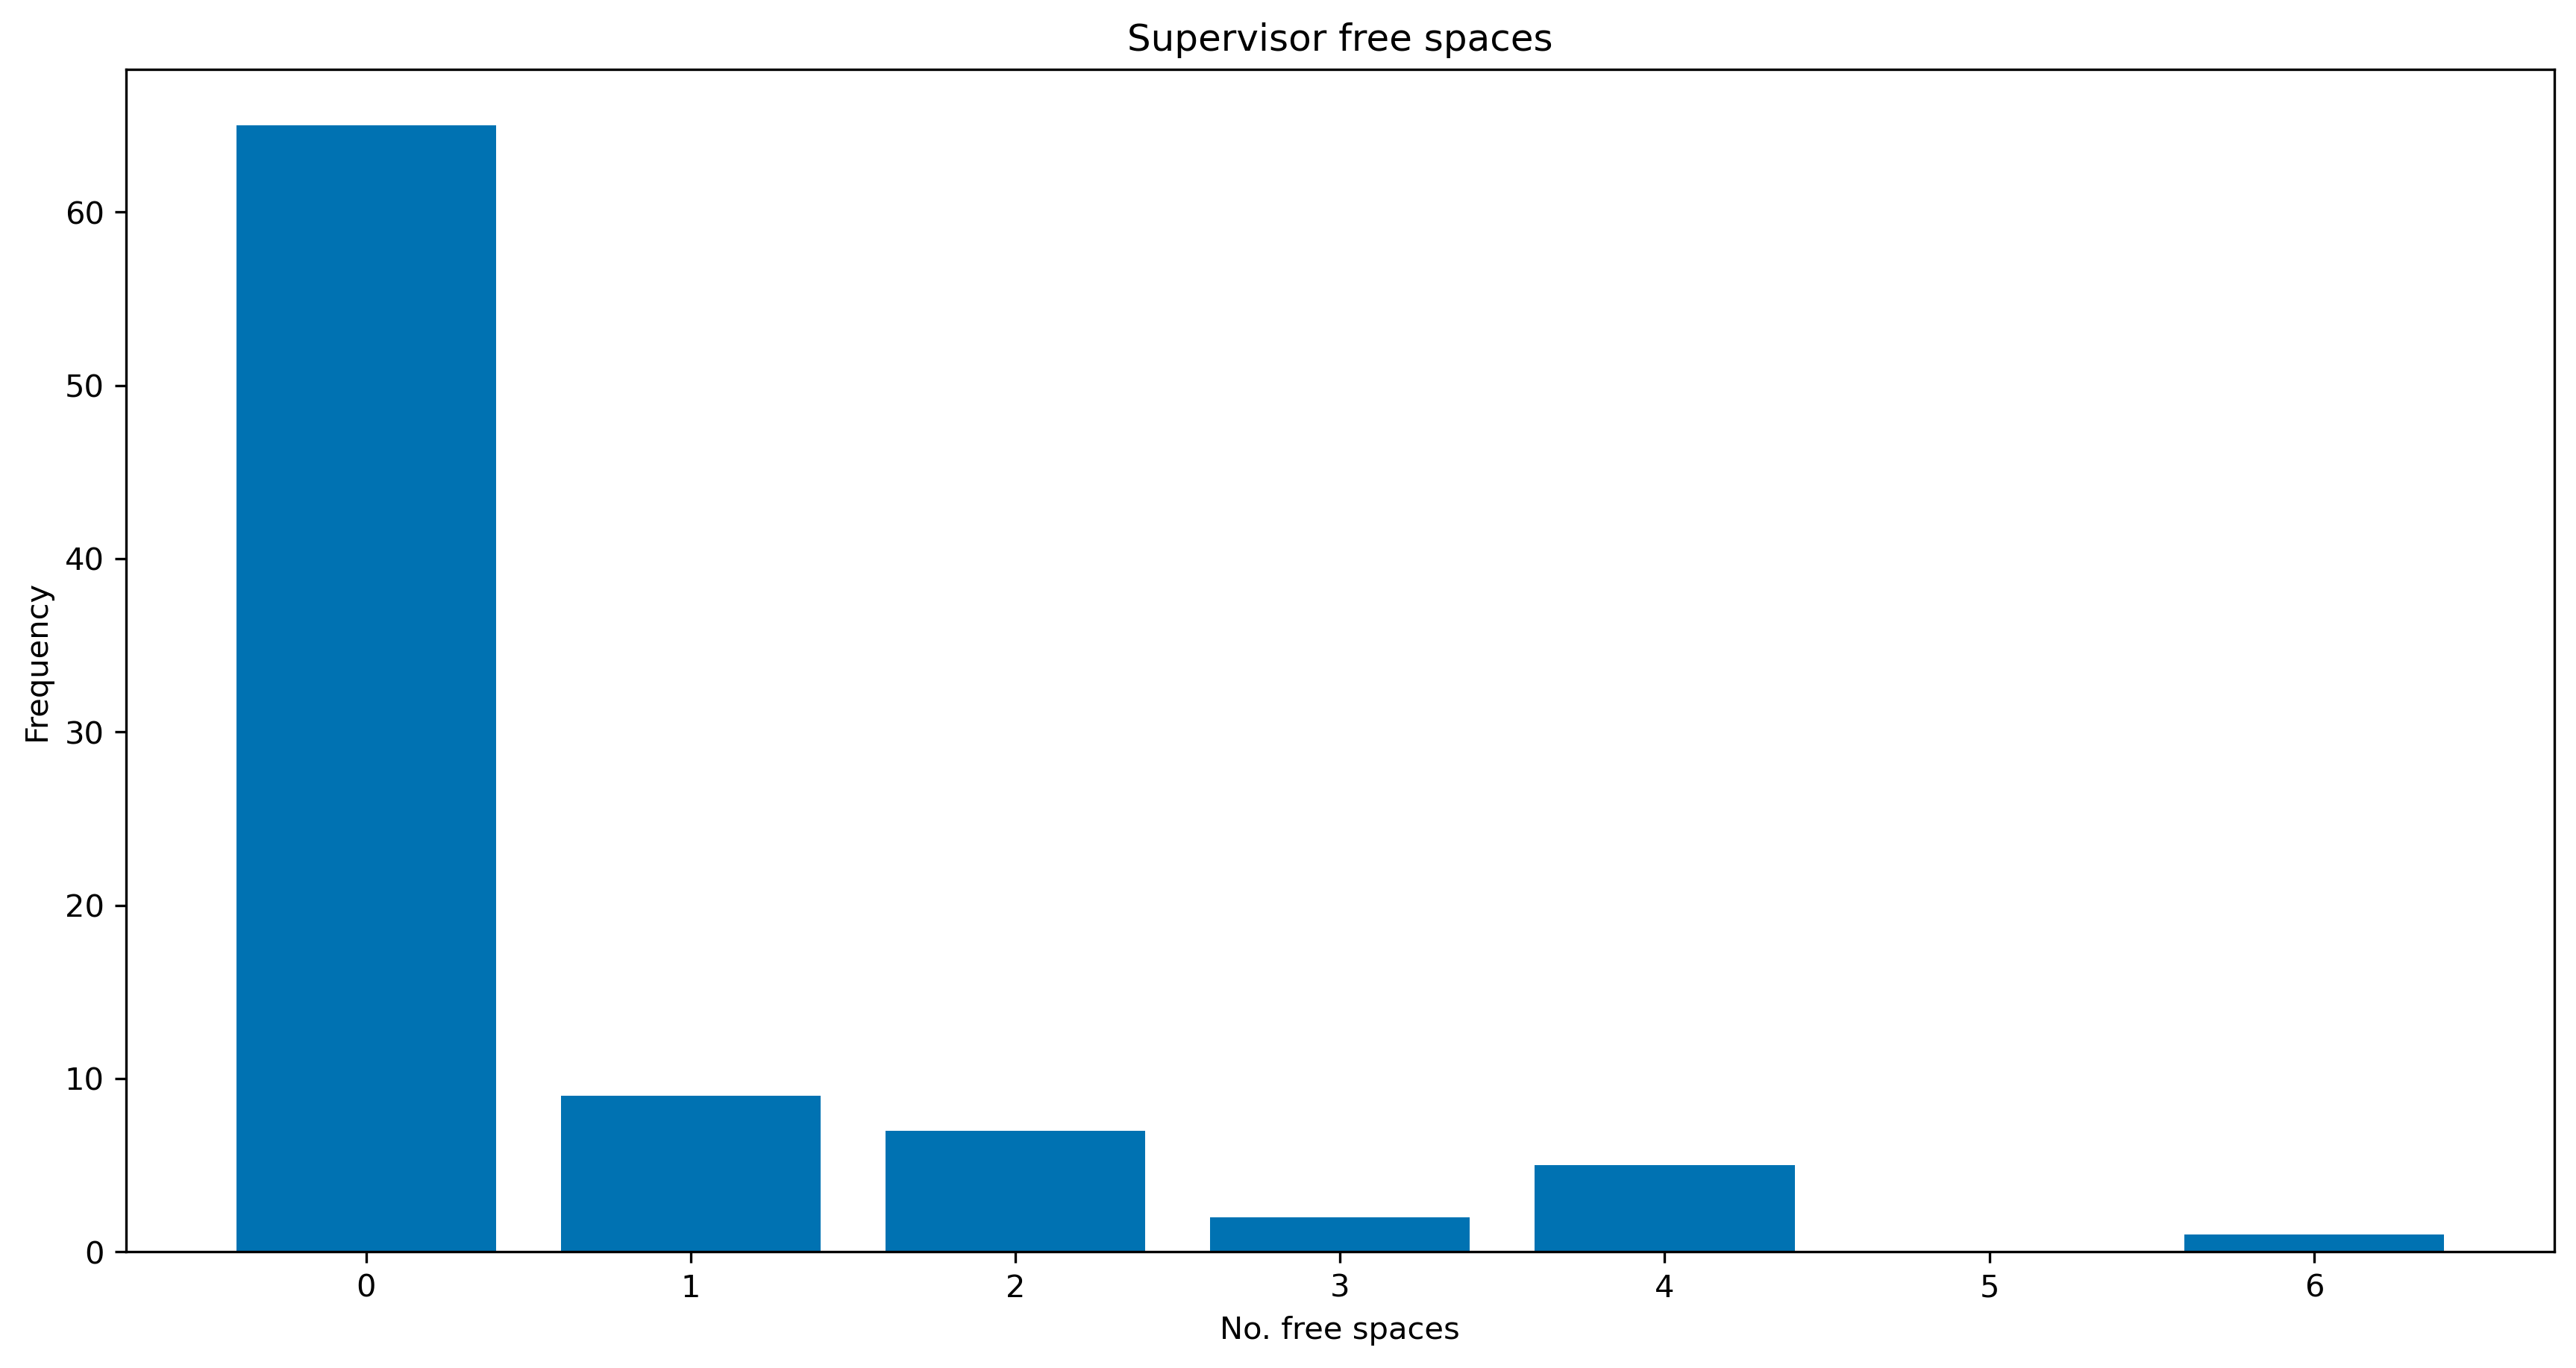

In [23]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = Counter(supervisor_free_spaces.values())
ax.bar(values.keys(), values.values())
ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_title("Supervisor free spaces")


Text(0.5, 1.0, 'Supervisor utilisation')

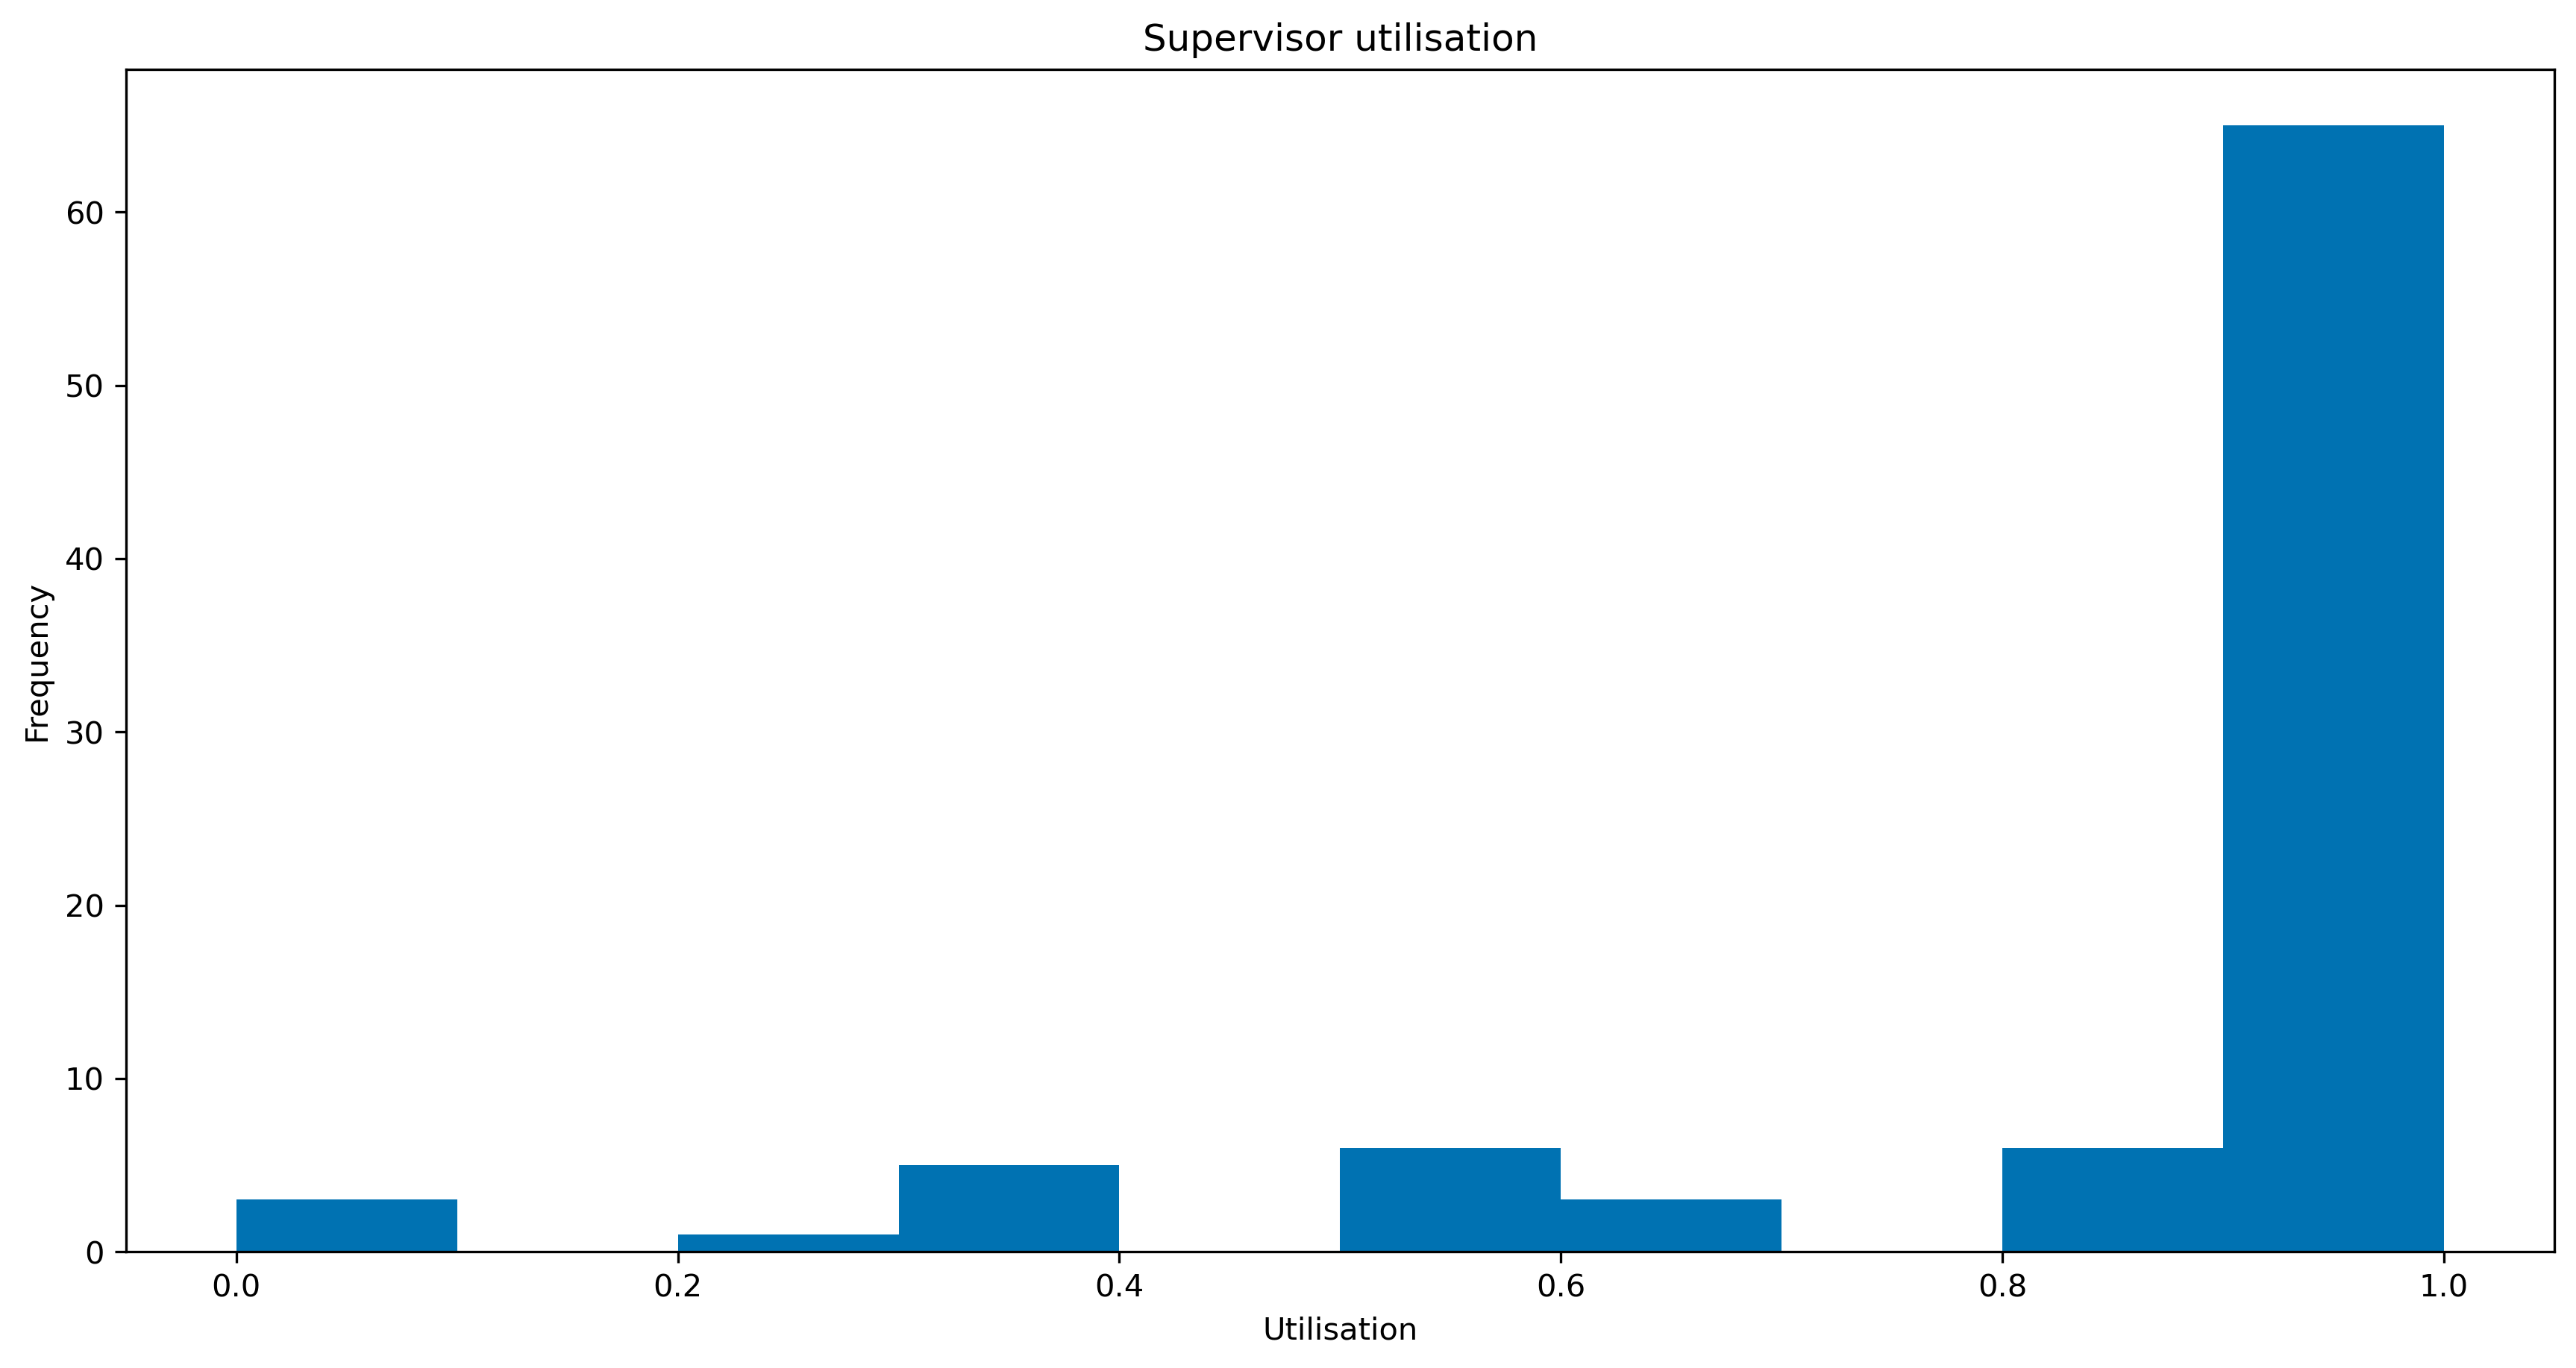

In [24]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = supervisor_utilisation.values()
ax.hist(values)
ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Supervisor utilisation")


## Projects


In [25]:
project_free_spaces = {
    project: project.capacity - len(project.matching) for project in game.projects
}

project_utilisation = {
    project: len(project.matching) / project.capacity for project in game.projects
}


Text(0.5, 1.0, 'Project free spaces')

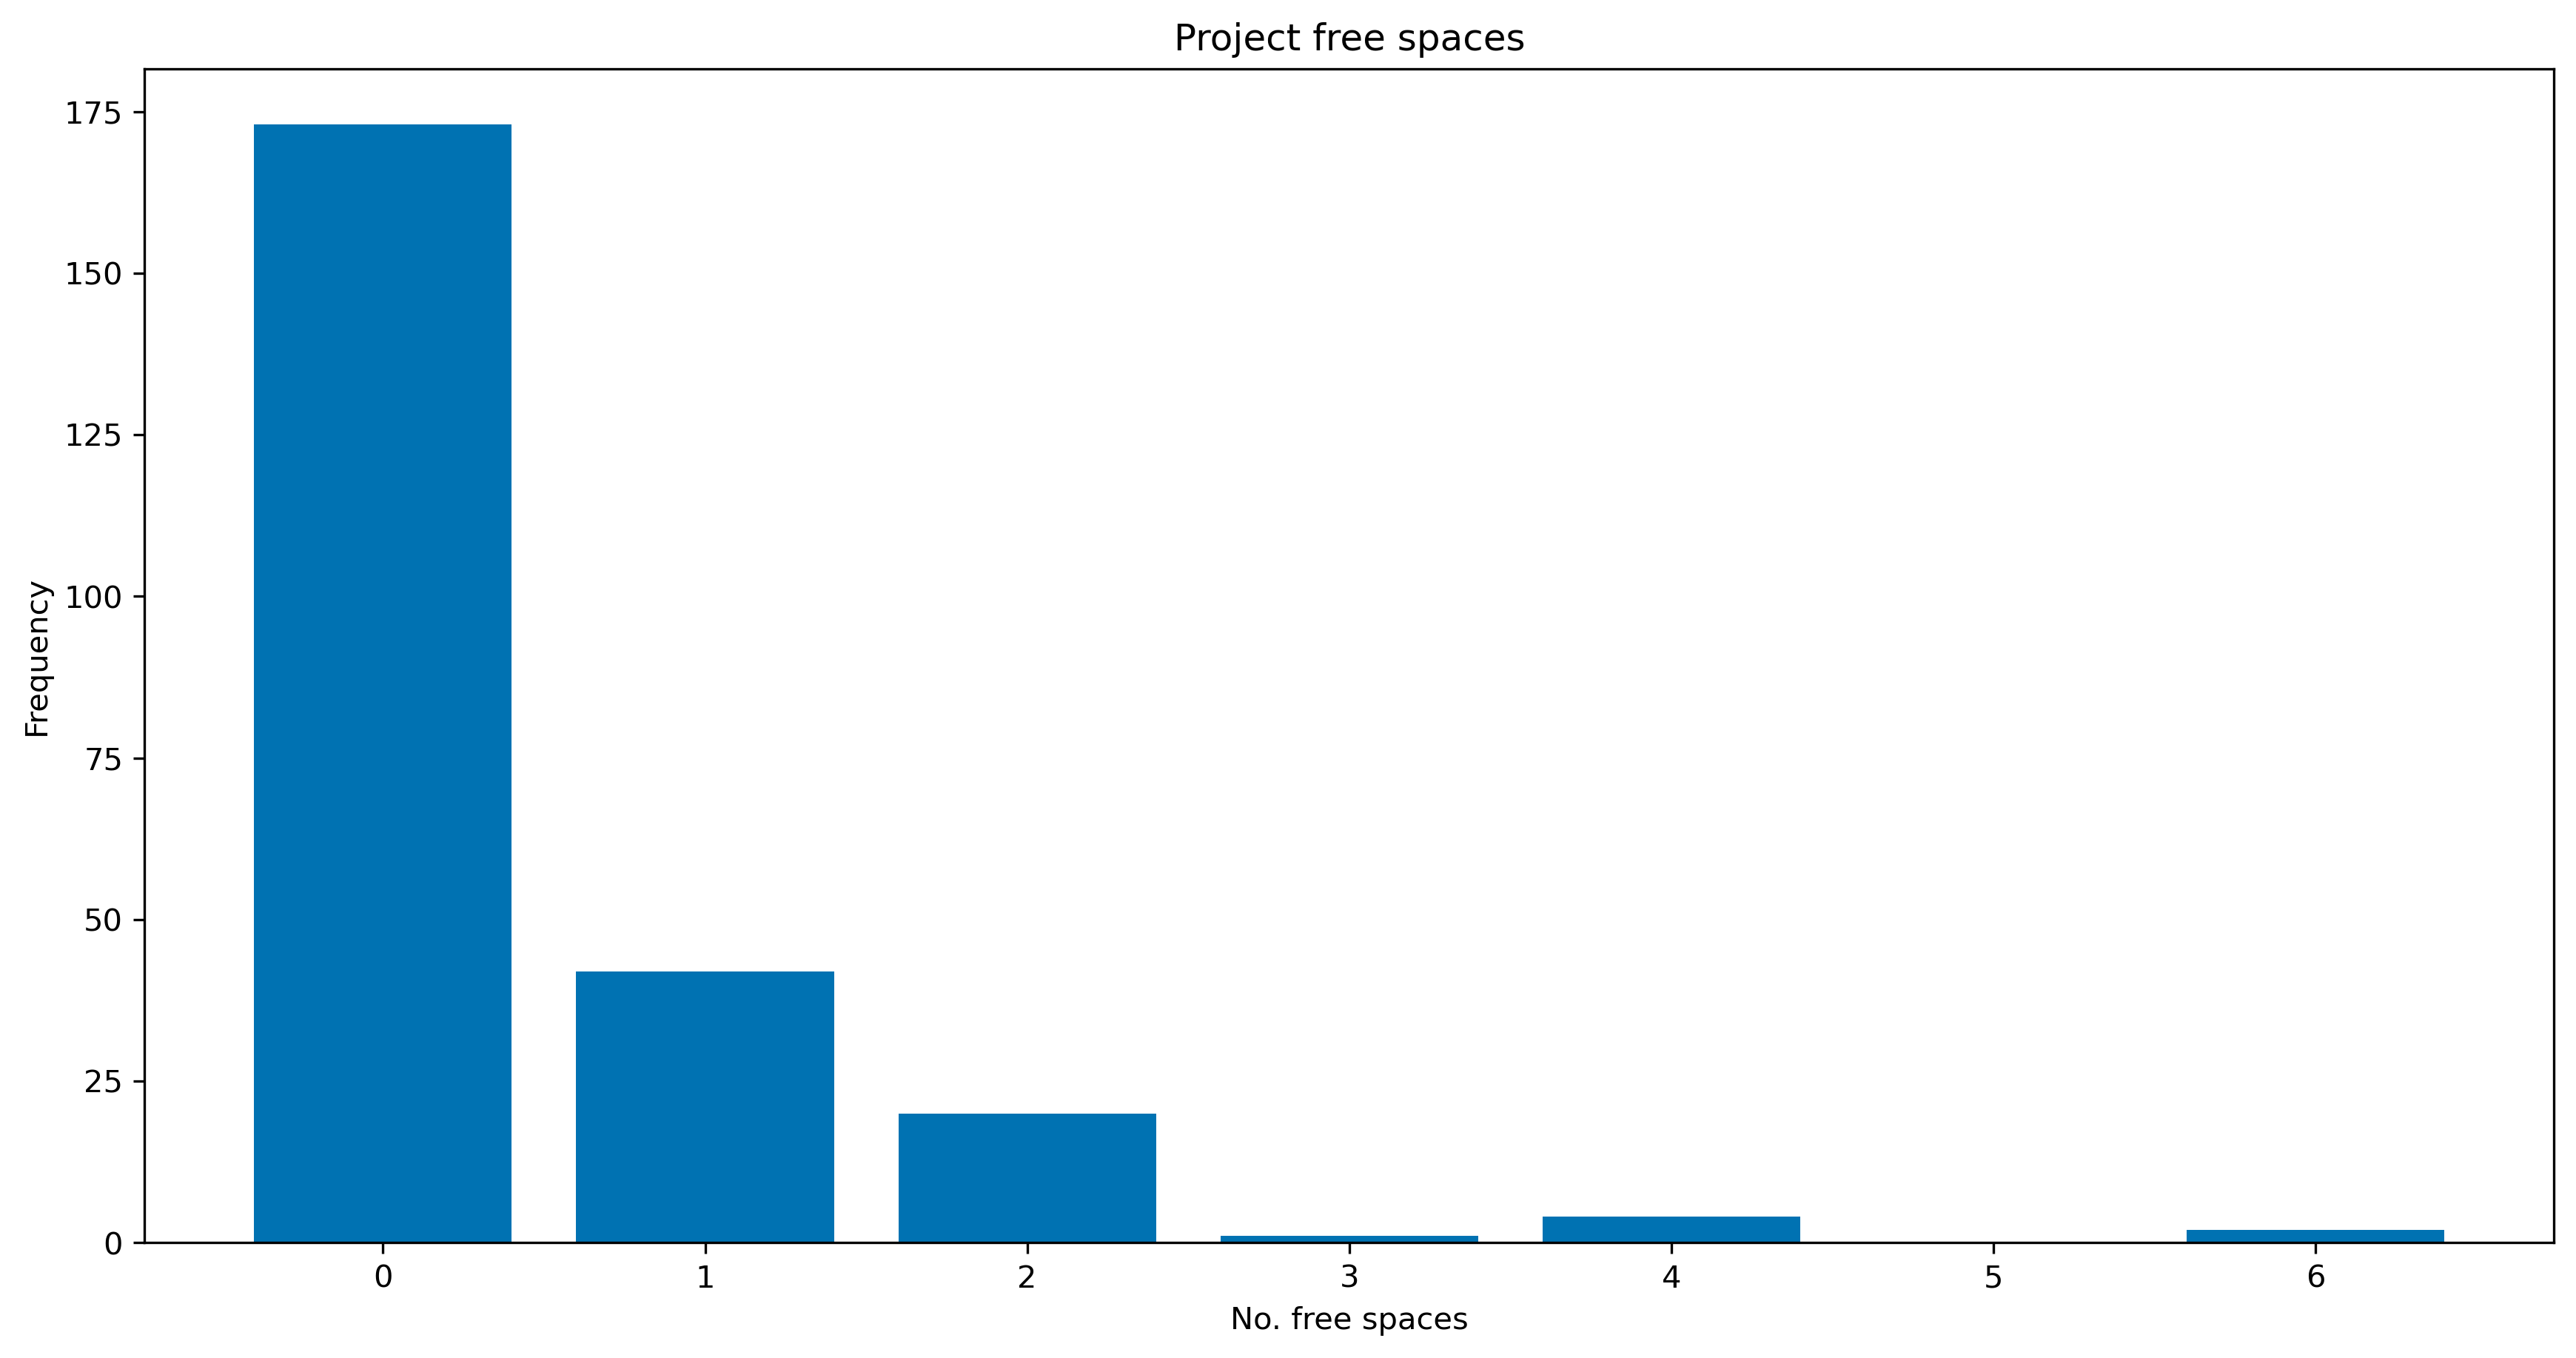

In [26]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = Counter(project_free_spaces.values())
ax.bar(values.keys(), values.values())
ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_title("Project free spaces")


Text(0.5, 1.0, 'Project utilisation')

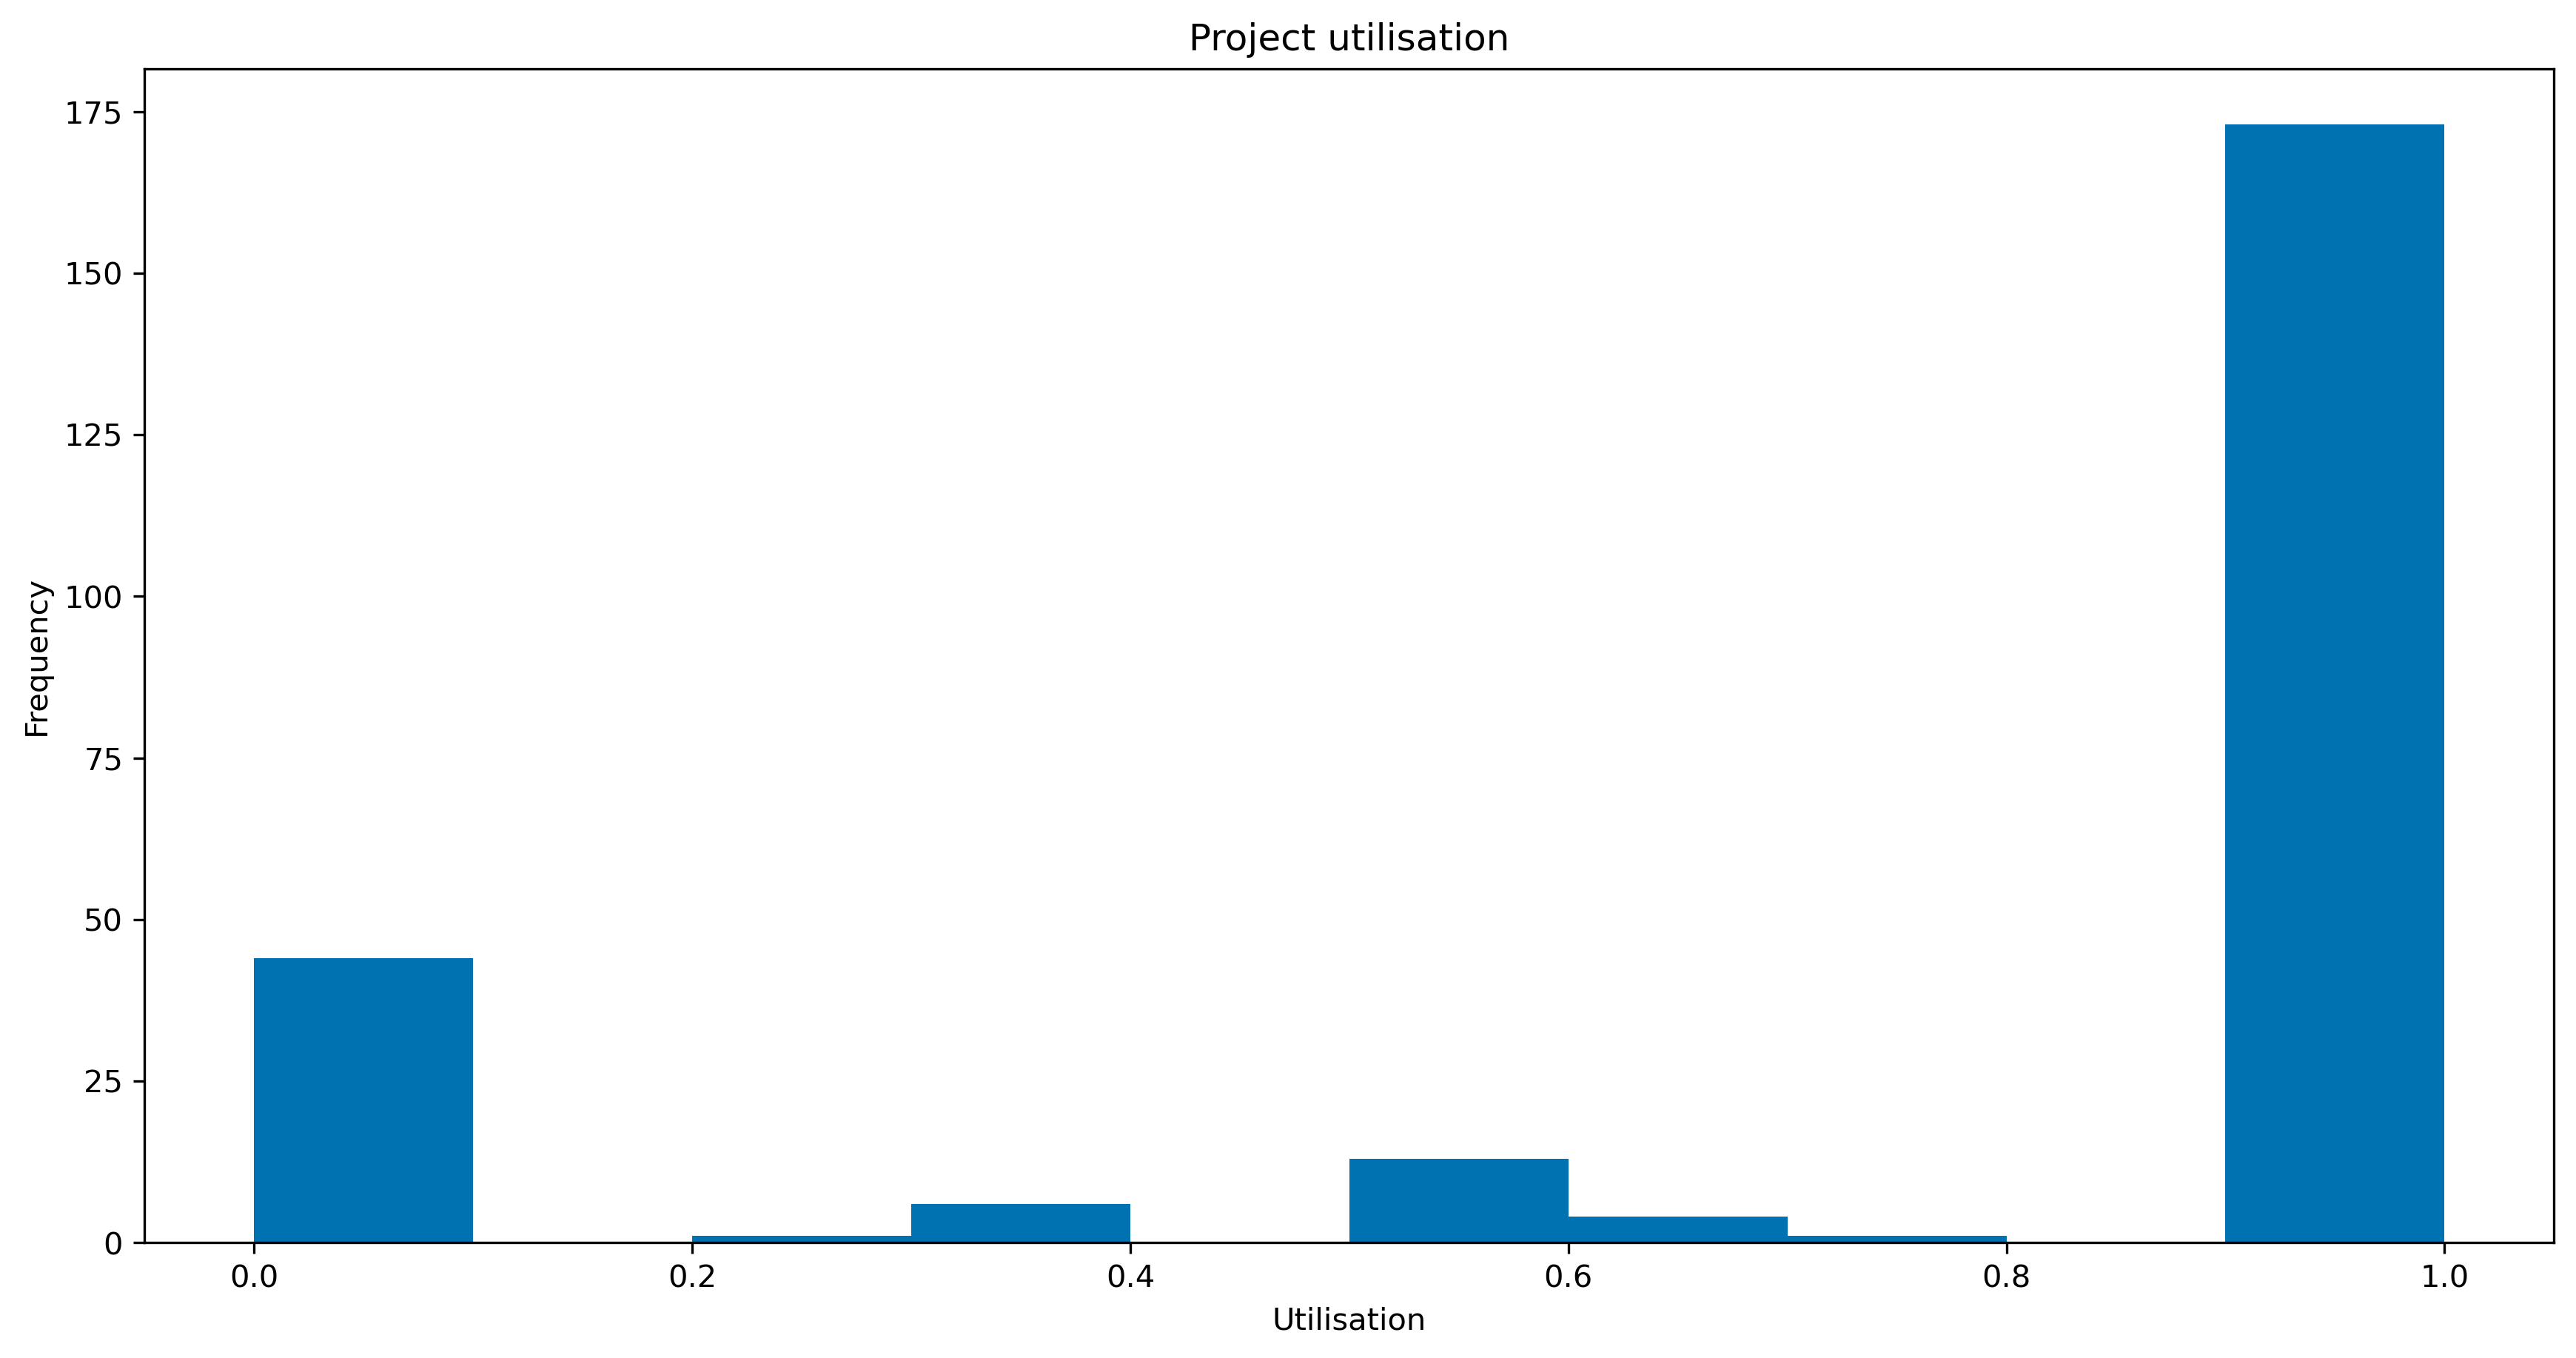

In [27]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = project_utilisation.values()
ax.hist(values)
ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Project utilisation")


## Students


In [28]:
invert_matching = {}
matching_rank = []
for project, students_ in matching.items():
    for student in students_:
        invert_matching[student.name] = project.name
        matching_rank.append(student._pref_names.index(project.name))


In [29]:
df = pd.DataFrame(
    {
        "student_number": list(invert_matching.keys()),
        "project": list(invert_matching.values()),
        "preference": matching_rank,
    }
)

order = students.set_index("student_number").index
df = df.set_index("student_number").reindex(order).reset_index()

df["rank"] = students["rank"]
unassigned_students = df[df["preference"].isnull()]


Text(0.5, 1.0, 'Student matching preferences')

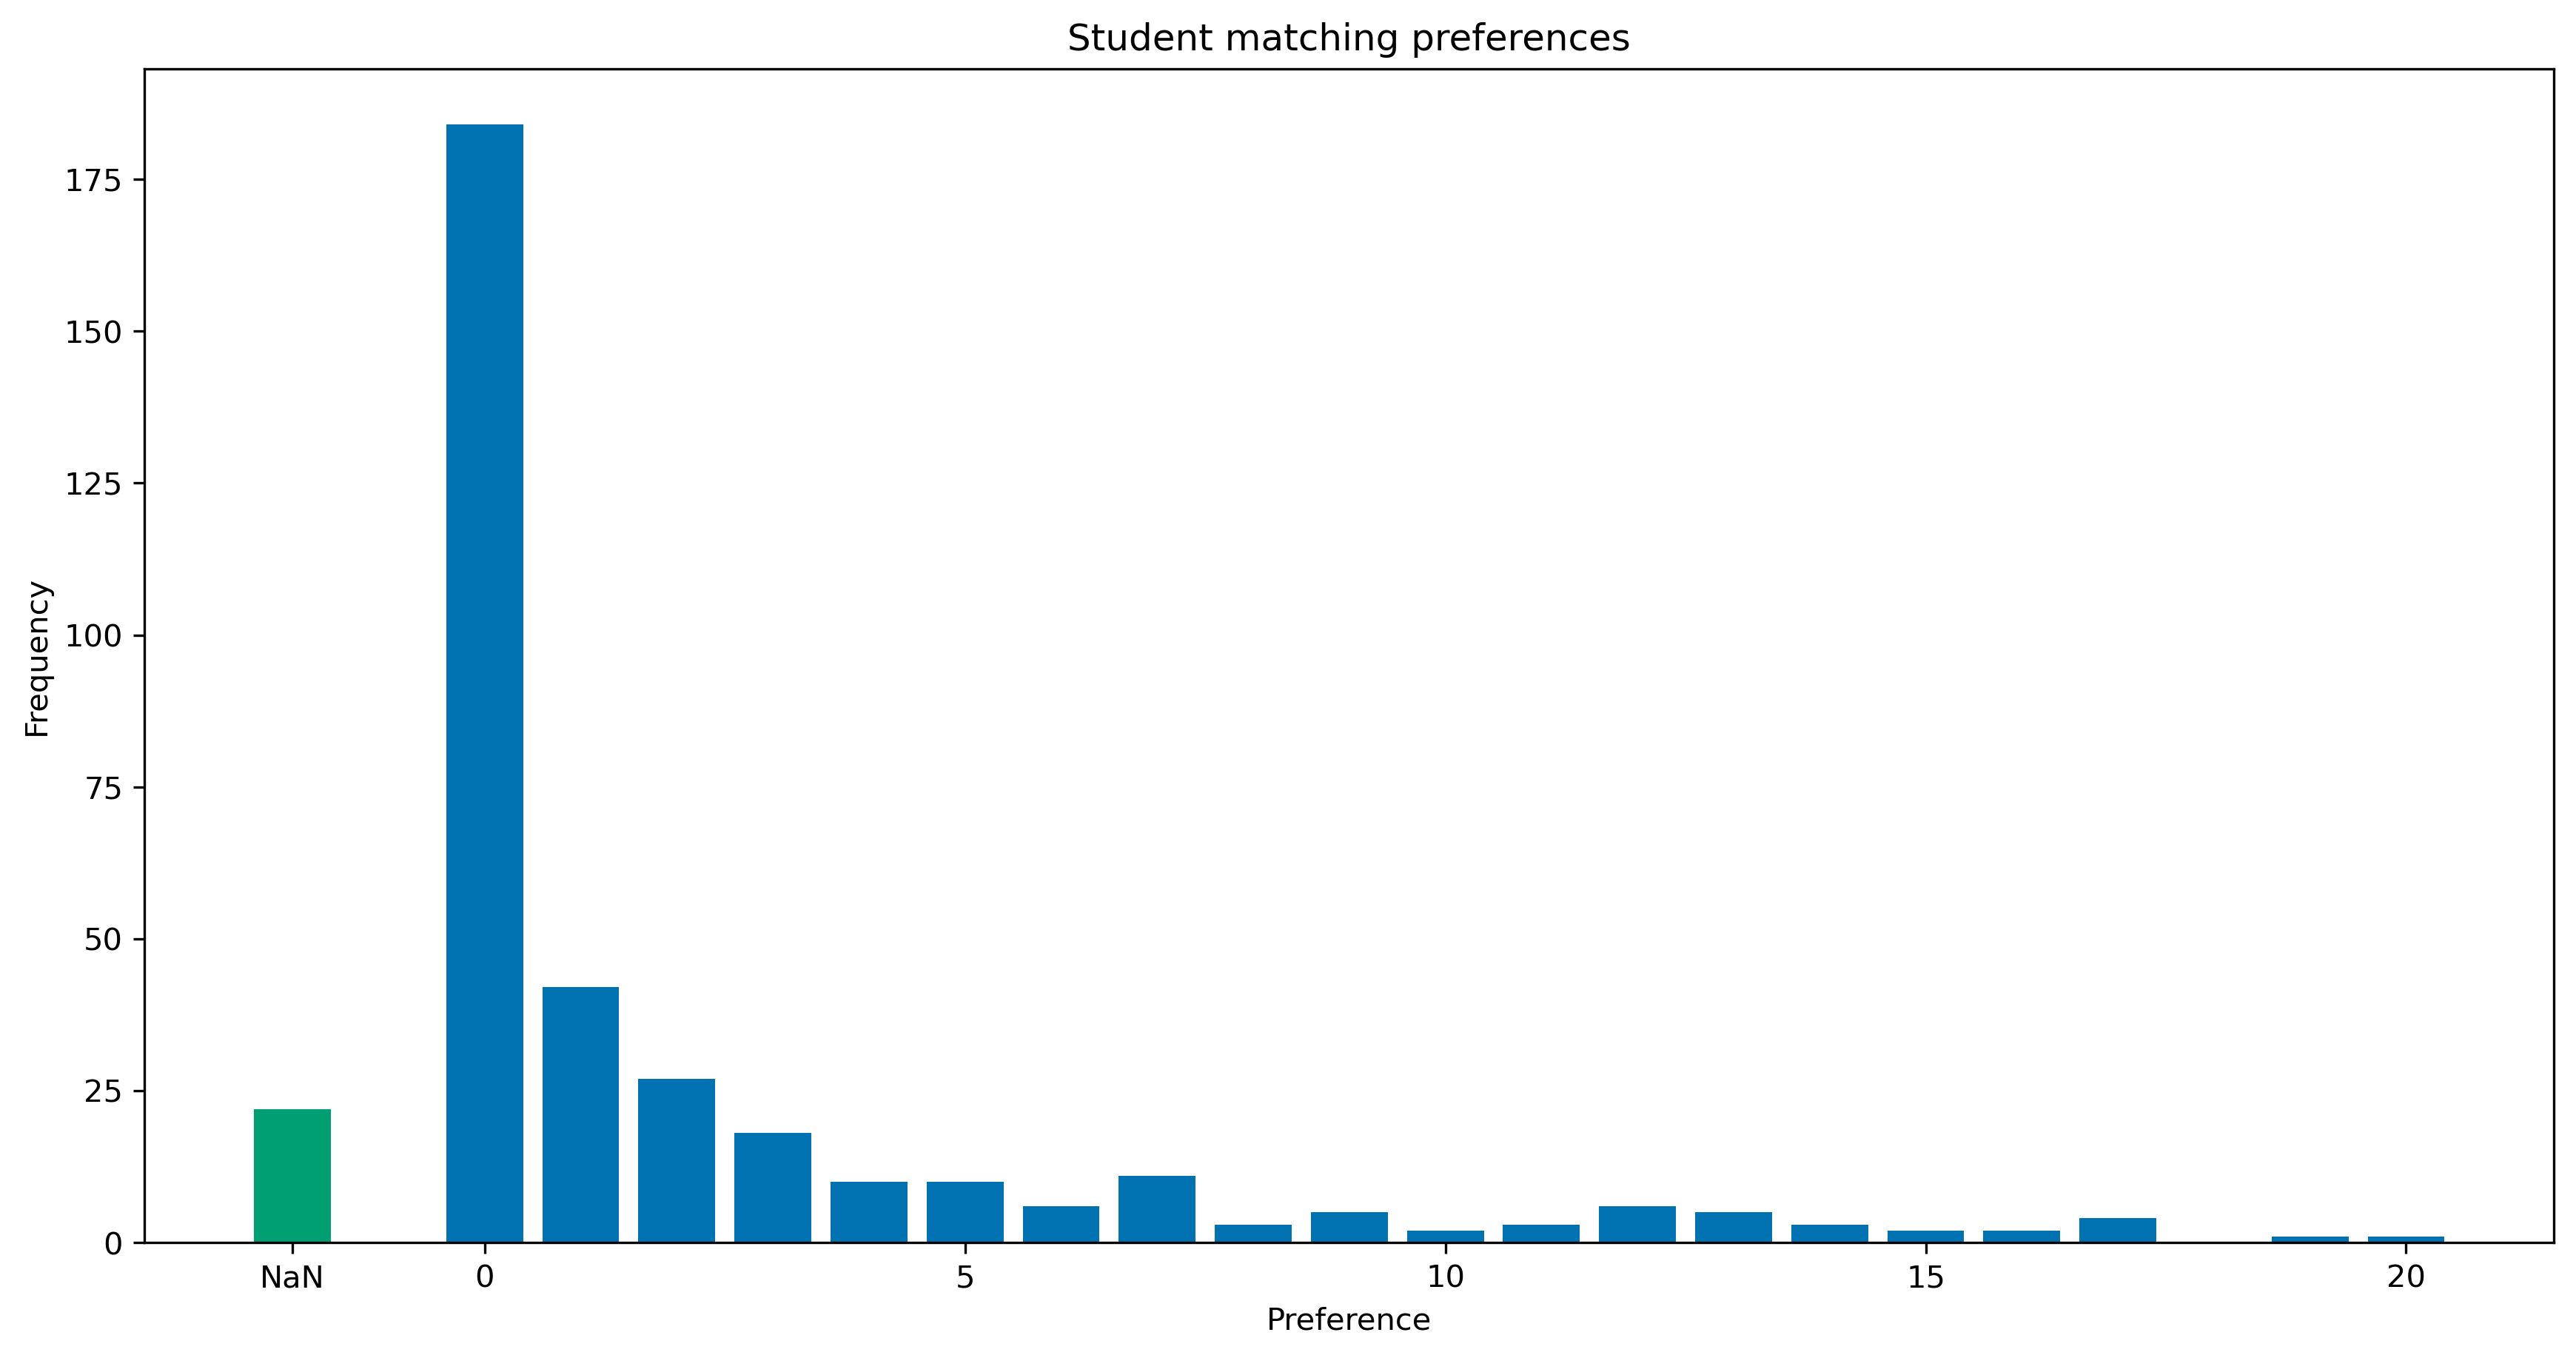

In [30]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = Counter(df["preference"])
ax.bar(values.keys(), values.values())
ax.bar(-2, len(unassigned_students))

ax.set_xticks([-2] + list(range(0, 21, 5)))
ax.set_xticklabels(["NaN"] + list(range(0, 21, 5)))
ax.set_xlabel("Preference")
ax.set_ylabel("Frequency")
ax.set_title("Student matching preferences")


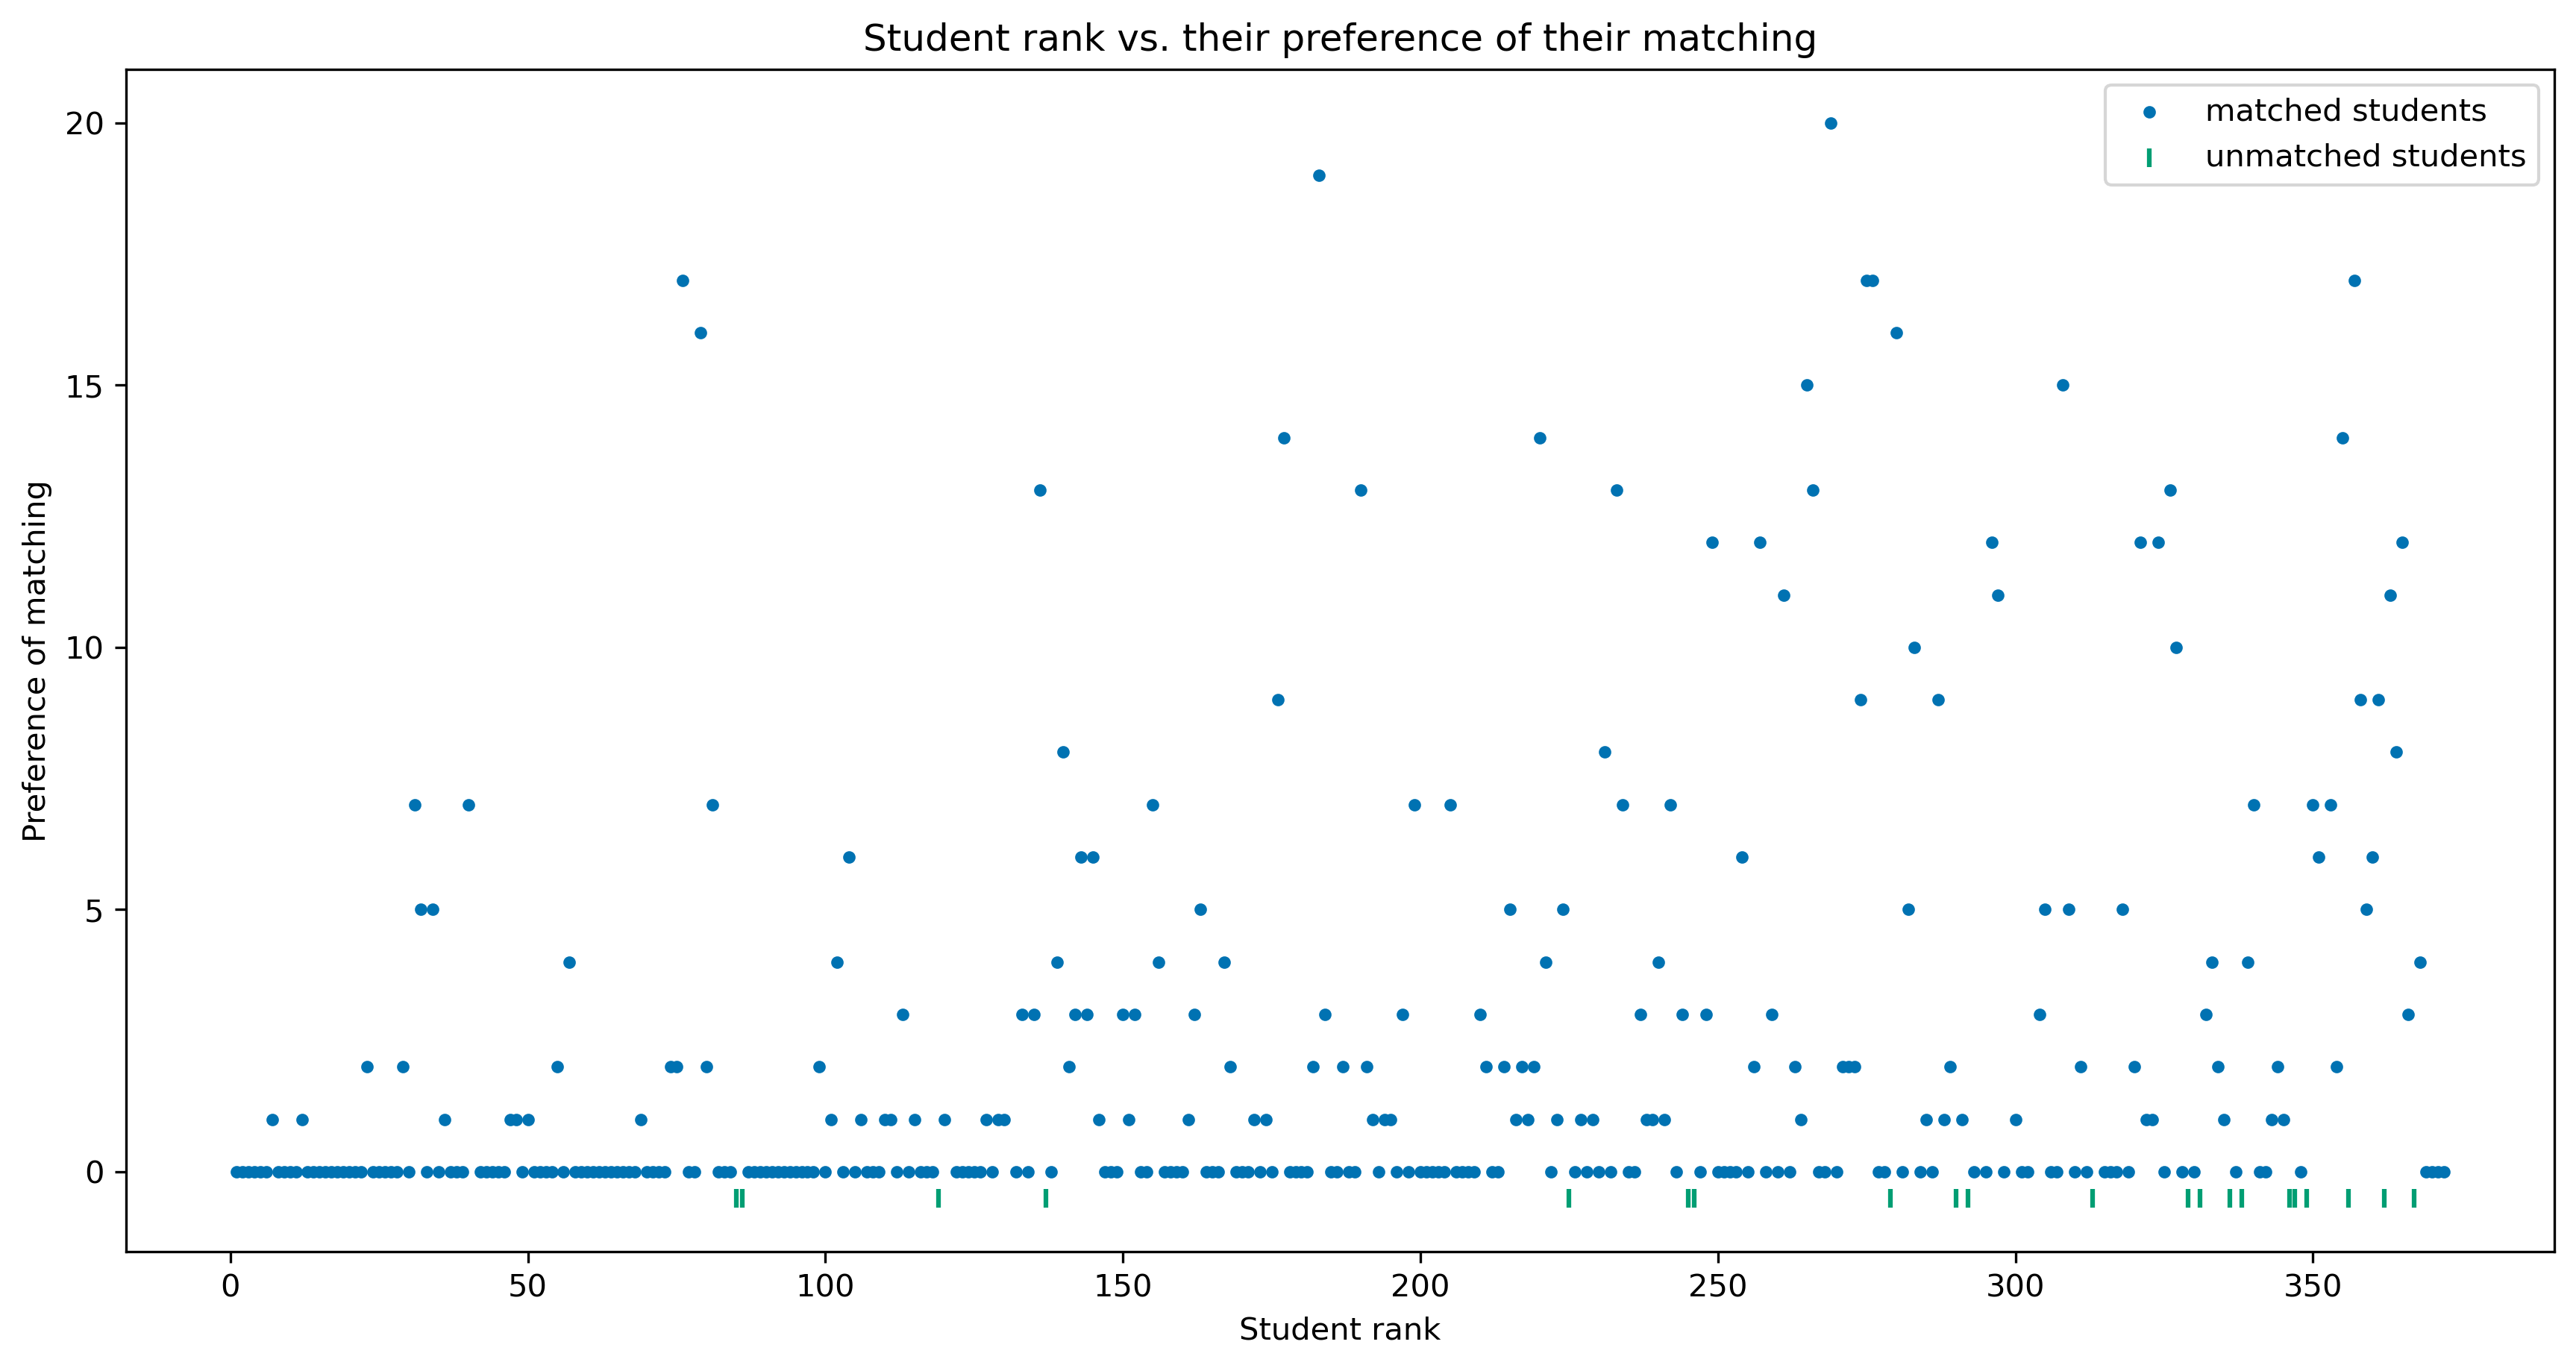

In [31]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

ax.scatter(df["rank"], df["preference"], marker=".", label="matched students")
ax.scatter(
    x=unassigned_students["rank"],
    y=[-0.5] * len(unassigned_students),
    marker="|",
    label="unmatched students",
)

ax.set_yticks(range(0, 21, 5))
ax.set_xlabel("Student rank")
ax.set_ylabel("Preference of matching")
ax.set_title("Student rank vs. their preference of their matching")
ax.legend()


In [32]:
order = df["student_number"].values
original_matches = (
    raw_students.set_index("University_number")
    .reindex(order)
    .reset_index()["Project Allocated"]
    .values
)
df["original_project"] = original_matches


In [33]:
def get_original_match_preference(row):
    """ Get the preference of the original match.
    If no match is available then return `nan` and if there is no preference, return -1. """

    name = row["student_number"]
    original_match = row["original_project"]
    prefs = students[students["student_number"] == name][
        list(range(22))
    ].values.tolist()[0]

    if pd.isnull(original_match):
        return np.nan
    if original_match not in prefs:
        return -1
    return prefs.index(original_match)


In [34]:
original_prefs = []
get_pref = lambda row: get_original_match_preference(row)
for _, row in df.iterrows():
    original_prefs.append(get_pref(row))


In [35]:
df["original_preference"] = original_prefs


In [36]:
df.head()


,student_number,project,preference,rank,original_project,original_preference
0,1616419,DP16,0.0,82.0,DP18,-1.0
1,1673247,AP05,3.0,237.0,DP18,14.0
2,1533191,NaN,NaN,346.0,DP18,-1.0
3,1505546,BP05,0.0,277.0,BL23,2.0
4,1601069,DL22,12.0,321.0,BL24,6.0


In [37]:
preferred = df[df["original_preference"] >= 0]
not_preferred = df[df["original_preference"] < 0]
original_unassigned = df[df["original_preference"].isnull()]


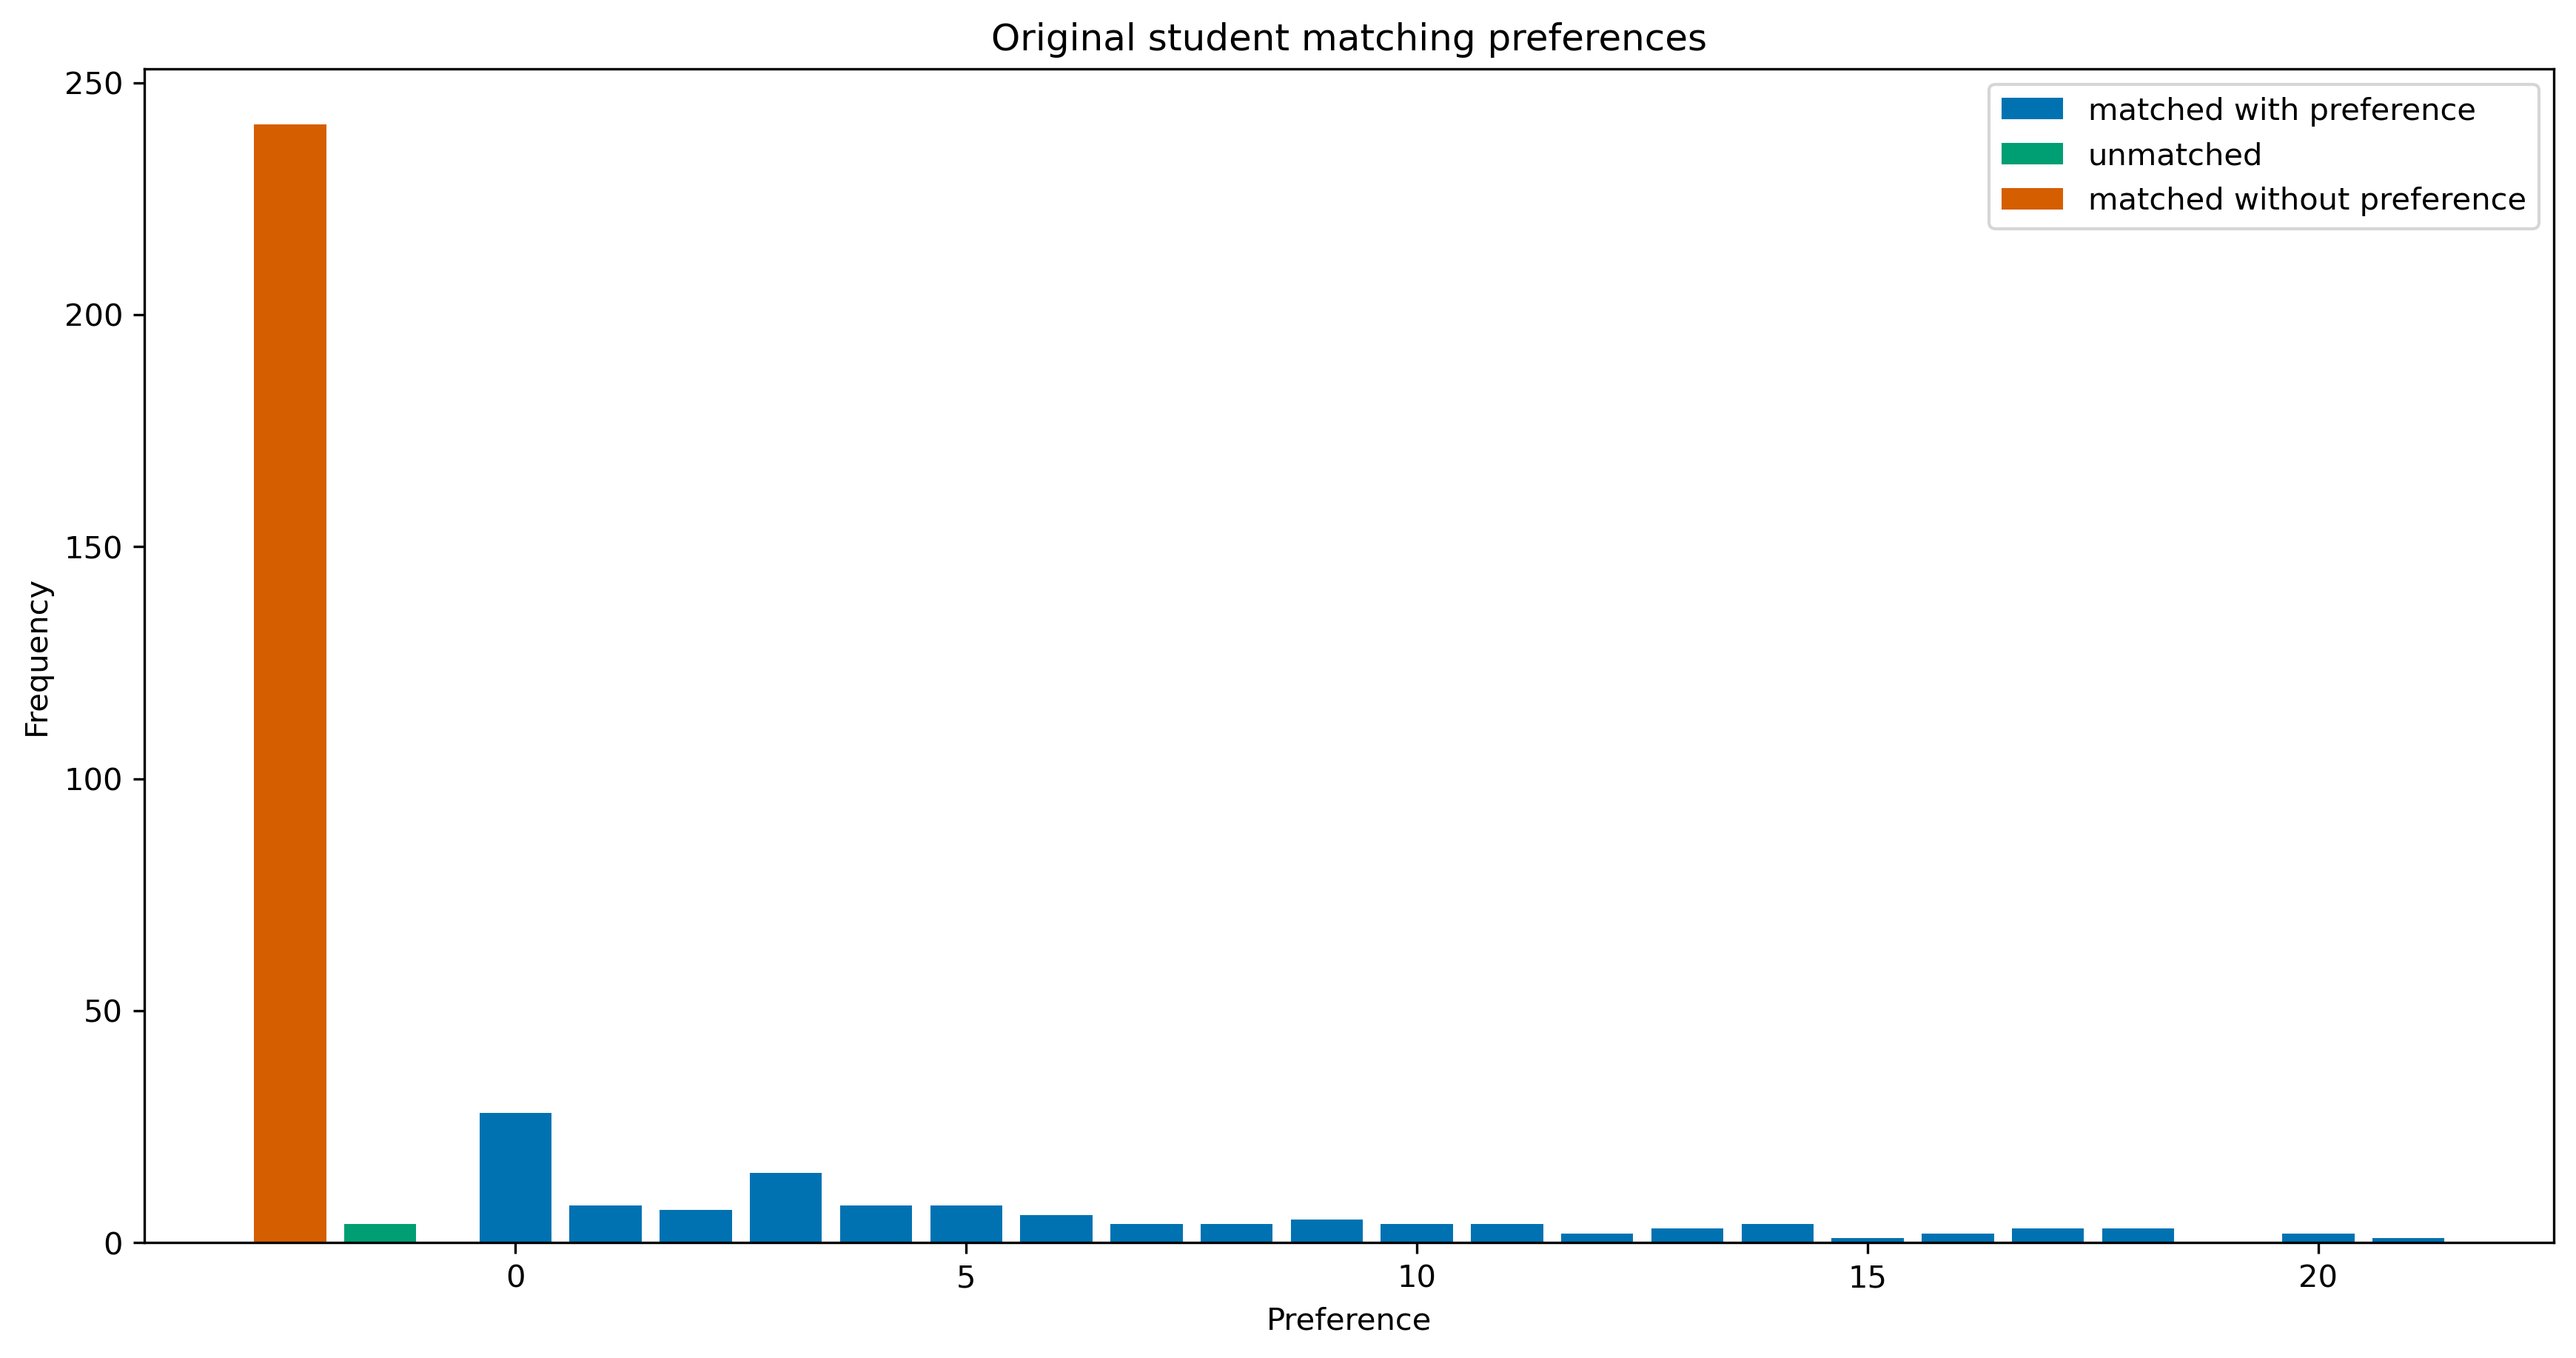

In [38]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

preferred_original_pref = Counter(preferred["original_preference"])
ax.bar(
    preferred_original_pref.keys(),
    preferred_original_pref.values(),
    label="matched with preference",
)
ax.bar(-1.5, len(original_unassigned), label="unmatched")
ax.bar(-2.5, len(not_preferred), label="matched without preference")

ax.set_xticks(list(range(0, 21, 5)))
ax.set_xticklabels(range(0, 21, 5))
ax.set_xlabel("Preference")
ax.set_ylabel("Frequency")
ax.set_title("Original student matching preferences")
ax.legend()


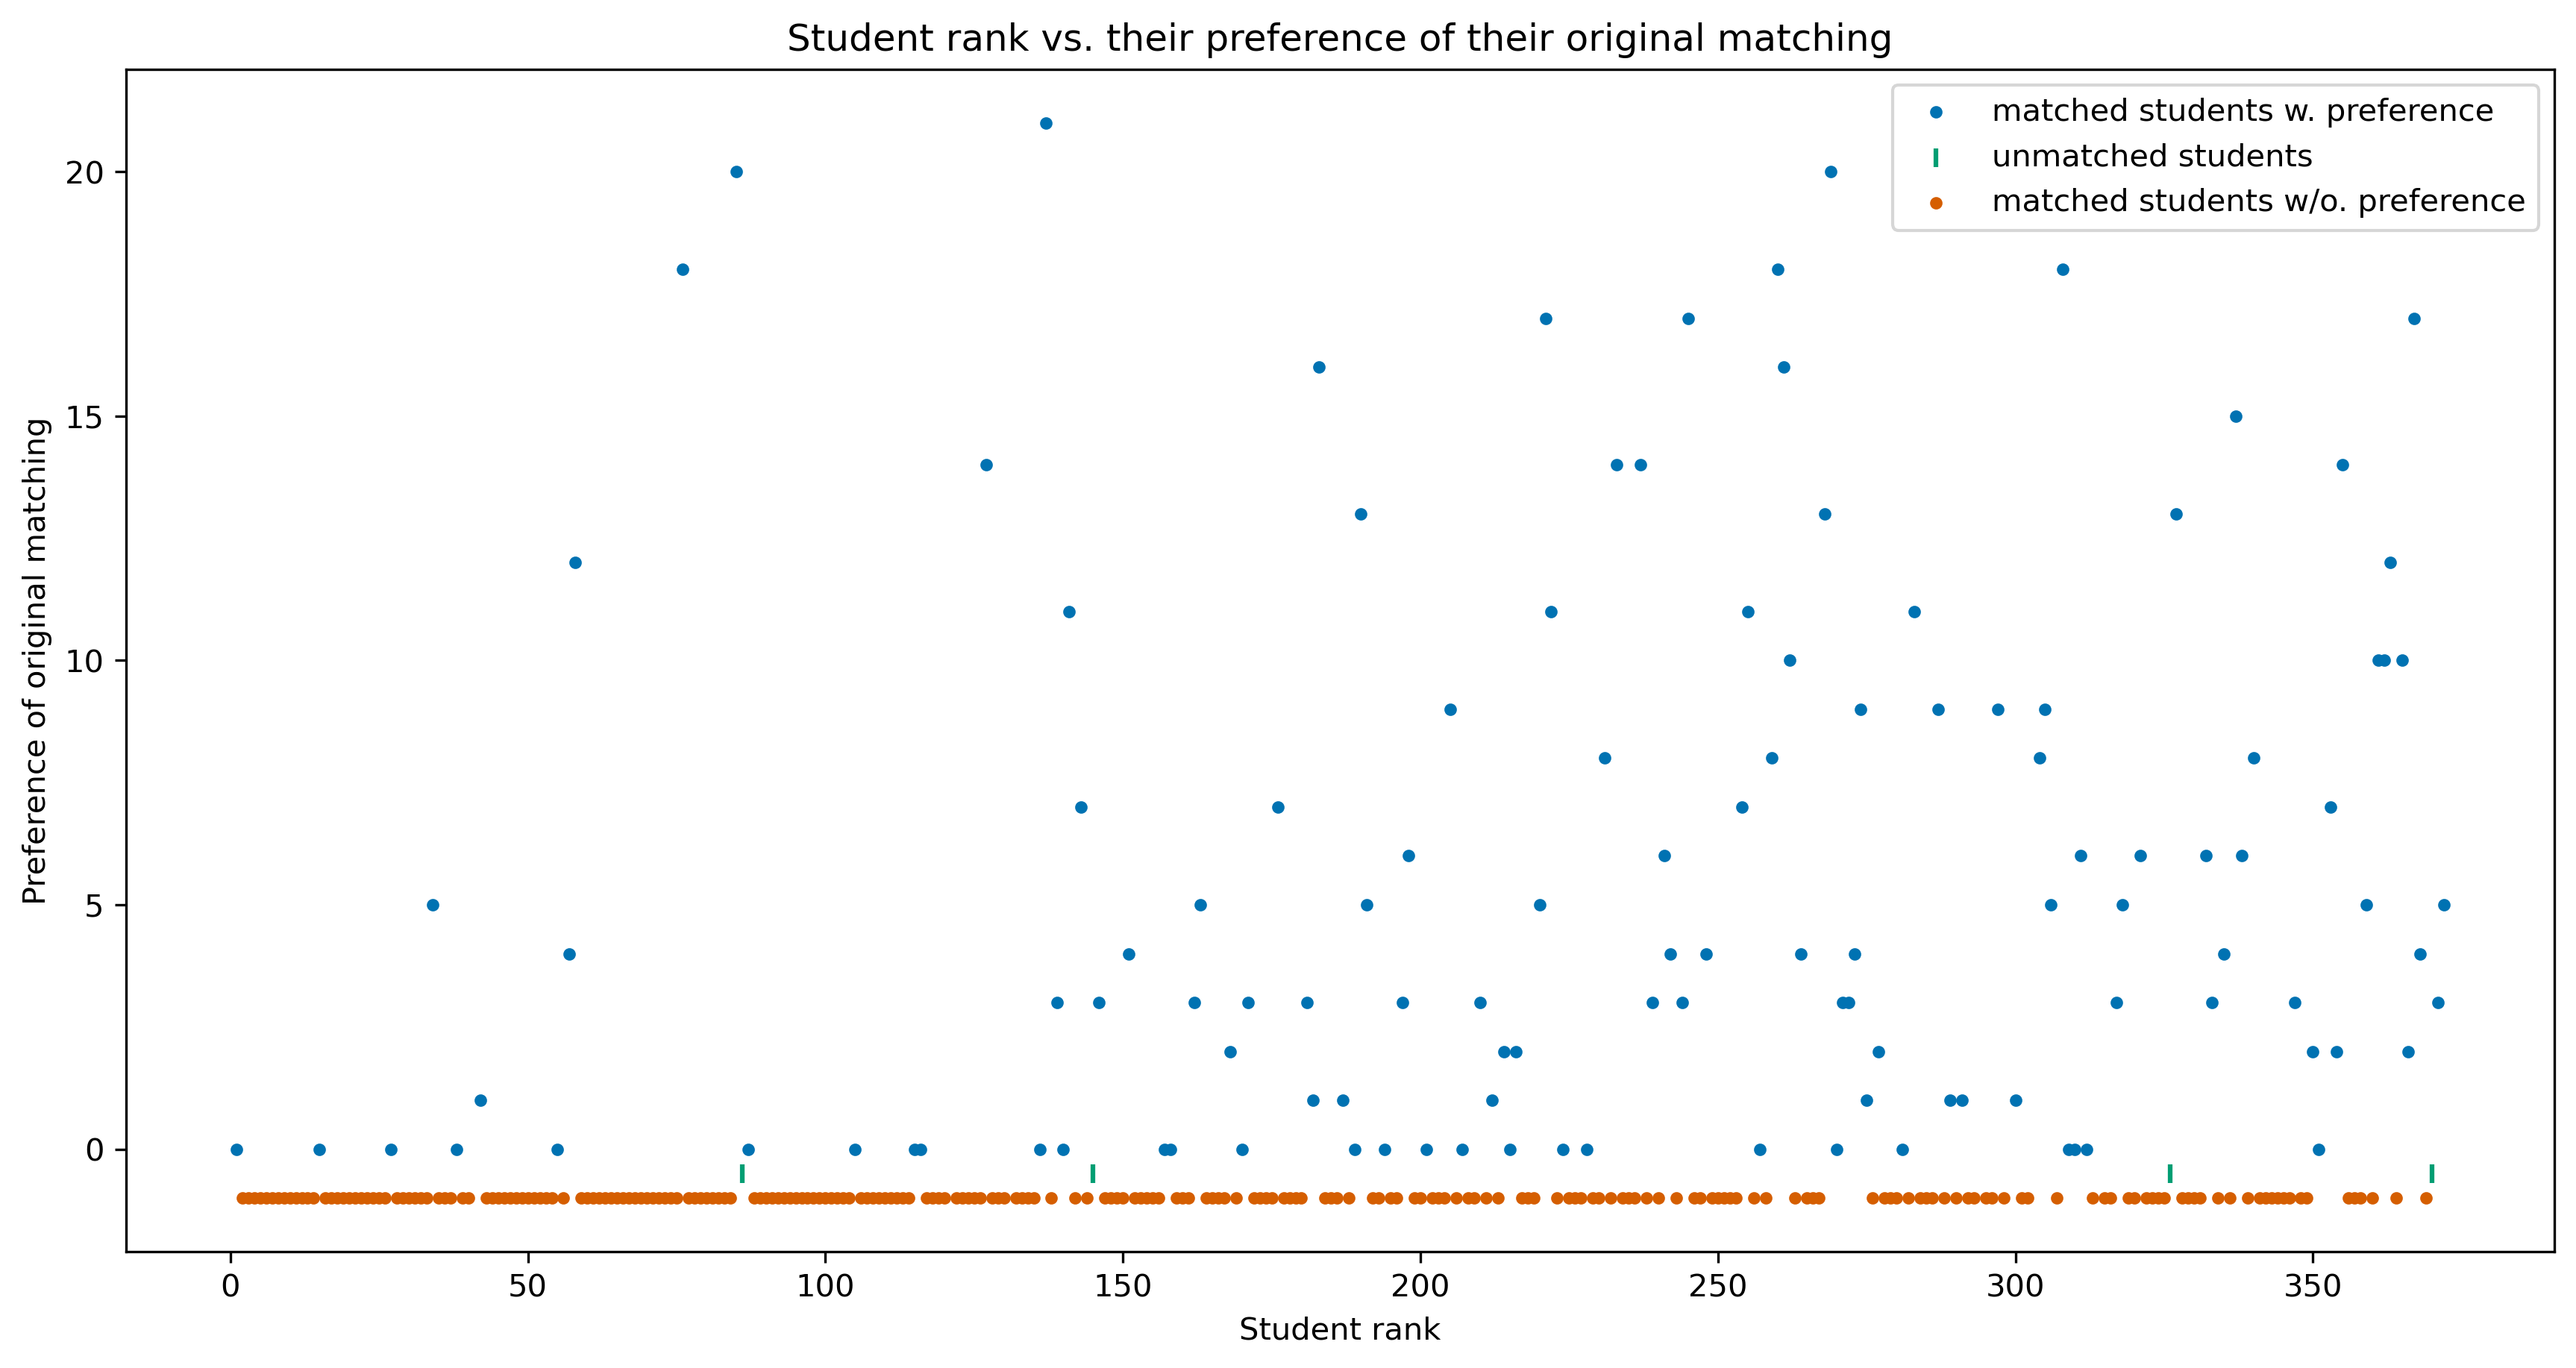

In [39]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

ax.scatter(
    preferred["rank"],
    preferred["original_preference"],
    marker=".",
    label="matched students w. preference",
)
ax.scatter(
    original_unassigned["rank"],
    [-0.5] * len(original_unassigned),
    marker="|",
    label="unmatched students",
)
ax.scatter(
    not_preferred["rank"],
    not_preferred["original_preference"],
    marker=".",
    label="matched students w/o. preference",
)

ax.set_yticks(range(0, 21, 5))
ax.set_xlabel("Student rank")
ax.set_ylabel("Preference of original matching")
ax.set_title("Student rank vs. their preference of their original matching")
ax.legend()


In [40]:
names = set(preferred["student_number"])

for name in not_preferred["student_number"].values:
    names.add(name)

for name in unassigned_students["student_number"].values:
    names.add(name)


In [41]:
missing_names = set(raw_students["University_number"].dropna().astype(int)).difference(
    names
)
missing_names


{1417852,
 1434273,
 1524856,
 1541731,
 1543623,
 1607855,
 1631343,
 1631445,
 1673219}

In [42]:
raw_students[raw_students["University_number"].isin(missing_names)][
    ["University_number", "Adjusted Rank"] + project_cols
]


,University_number,Adjusted Rank,Project 1,Project 2,Project 3,Project 4,Project 5,Project 6,Project 7,Project 8,...,Project 13,Project 14,Project 15,Project 16,Project 17,Project 18,Project 19,Project 20,Project 21,Project 22
121,1631445.0,NaN,AL09,AL10,AP08,AP14,AP18,BL08,BL18,BL19,...,AP11,AP13,AP18,AP15,AP17,BL09,AP15,AP24,AP23,AP25
135,1417852.0,342.0,EP32,EP03,EL06,EL05,EP28,EP17,EP30,EP40,...,EP15,EP16,ES02,EP22,EP23,EL01,EP42,EP43,EP01,EL03
174,1607855.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,1541731.0,249.0,CP13,EP10,EP11,EP16,EP22,CP11,EP09,CP24,...,EP36,EP23,EP42,EP40,EP43,EP13,AP25,CP10,EP35,EP24
312,1673219.0,307.0,AP18,BL17,BL16,CL05,DL05,EP34,EP35,BL12,...,DL19,CL04,AP17,BL18,AL09,CL07,BL14,DE01,DS01,DP04
362,1631343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,1434273.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,1543623.0,NaN,AP29,CP02,AP04,AP06,AP15,AP21,AP22,AP19,...,CP16,CP20,CP21,EP34,EP29,EP35,CP12,CP13,AP13,AP16
373,1524856.0,352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
students[students["student_number"].isin(missing_names)]


,student_number,rank,0,1,2,3,4,5,6,7,...,12,13,14,15,16,17,18,19,20,21
135,1417852,342,EP32,EP03,EL06,EL05,EP28,EP17,EP30,EP40,...,EP15,EP16,ES02,EP22,EP23,EL01,EP42,EP43,EP01,EL03
241,1541731,249,CP13,EP10,EP11,EP16,EP22,CP11,EP09,CP24,...,EP36,EP23,EP42,EP40,EP43,EP13,AP25,CP10,EP35,EP24
312,1673219,307,AP18,BL17,BL16,CL05,DL05,EP34,EP35,BL12,...,DL19,CL04,AP17,BL18,AL09,CL07,BL14,DE01,DS01,DP04


In [44]:
def get_number_of_matches(name, party, game):

    for player in vars(game)[party]:
        if player.name == name:
            return len(player.matching)


def get_capacity(name, party, game):

    for player in vars(game)[party]:
        if player.name == name:
            return player.capacity


In [45]:
project_with_space_names = [
    project.name
    for project in game.projects
    if len(project.matching) < project.capacity
] + list(unranked_projects)

supervisor_with_space_names = [
    supervisor.name
    for supervisor in game.supervisors
    if len(supervisor.matching) < supervisor.capacity
] + list(unranked_supervisors)

projects_with_space = projects[
    (projects["project_code"].isin(project_with_space_names))
    & (projects["supervisor"].isin(supervisor_with_space_names))
]

projects_with_space["supervisor_capacity"] = projects_with_space["supervisor"].apply(
    lambda x: get_capacity(x, "supervisors", game)
)
projects_with_space["project_matches"] = projects_with_space["project_code"].apply(
    lambda x: get_number_of_matches(x, "projects", game)
)
projects_with_space["supervisor_matches"] = projects_with_space["supervisor"].apply(
    lambda x: get_number_of_matches(x, "supervisors", game)
)

projects_with_space = projects_with_space[
    [
        "project_code",
        "project_capacity",
        "project_matches",
        "supervisor",
        "supervisor_capacity",
        "supervisor_matches",
    ]
]


In [46]:
projects_with_space.set_index(["supervisor", "project_code"]).sort_index()


,,project_capacity,project_matches,supervisor_capacity,supervisor_matches
supervisor,project_code,,,,
Adrian Harwood,DP18,3,2.0,3,2
Alan Watson,BL23,1,0.0,6,5
Andrew Shore,BP06,4,3.0,6,5
Barend H. J. De Graaf,CP05,2,0.0,4,2
Carsten Muller,EL08,2,0.0,6,4
Cedric Berger,EL09,1,0.0,2,1
Colin Berry,EP36,5,3.0,5,3
Emyr Lloyd-Evans,DL20,2,1.0,6,5
Frank Hailer,EP42,3,1.0,6,4
